In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import librosa
import librosa.display
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import torchaudio
from sklearn.model_selection import train_test_split
import os
import random
import time
import copy
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("Torchaudio Version: ",torchaudio.__version__)

c:\users\adisa\.conda\envs\ai\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


PyTorch Version:  1.8.1
Torchvision Version:  0.9.1
Torchaudio Version:  0.8.1


# Parameters

In [3]:
data_dir = "./data"
batch_size = 128
num_epochs = 10
classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'follow', 'forward', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'no', 'off', 'on', 'right', 'sheila', 'stop', 'tree', 'up', 'visual', 'wow', 'yes']
num_classes = len(classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = 1

if(n_gpu > 0):
    print("Using {} GPU(s) for training!".format(n_gpu))
else:
    print("Using CPU for training!")

Using 1 GPU(s) for training!


# Speech commands dataset

## Load, explore and augment data

In [5]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")
val_set = SubsetSC("validation")

In [6]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(classes.index(word))

def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return classes[index]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


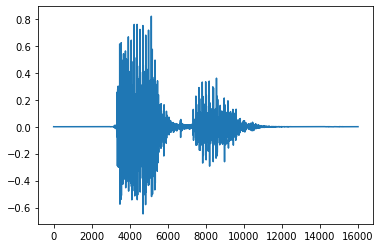

In [7]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[4]
num_channels = waveform.shape[0]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [14]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

# Transformations
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=8000)

# Create datasets
datasets_dict = {
    "train": train_set,
    "test": test_set,
    "val": val_set,
}

# Create dataloaders
dataloaders_dict = {mode: DataLoader(datasets_dict[mode], batch_size=batch_size, 
                                                   shuffle=True, collate_fn=collate_fn, pin_memory=False, num_workers=0) 
                    for mode in ['train', 'test', 'val']}

print("Data loaded successfully!")

Data loaded successfully!


In [8]:
print("Number of audio samples: ", len(train_set) + len(test_set) + len(val_set))
print("Samples in trainig set: ", len(train_set))
print("Samples in test set: ", len(test_set))
print("Samples in validation set: ", len(val_set))

Number of audio samples:  126815
Samples in trainig set:  105829
Samples in test set:  11005
Samples in validation set:  9981


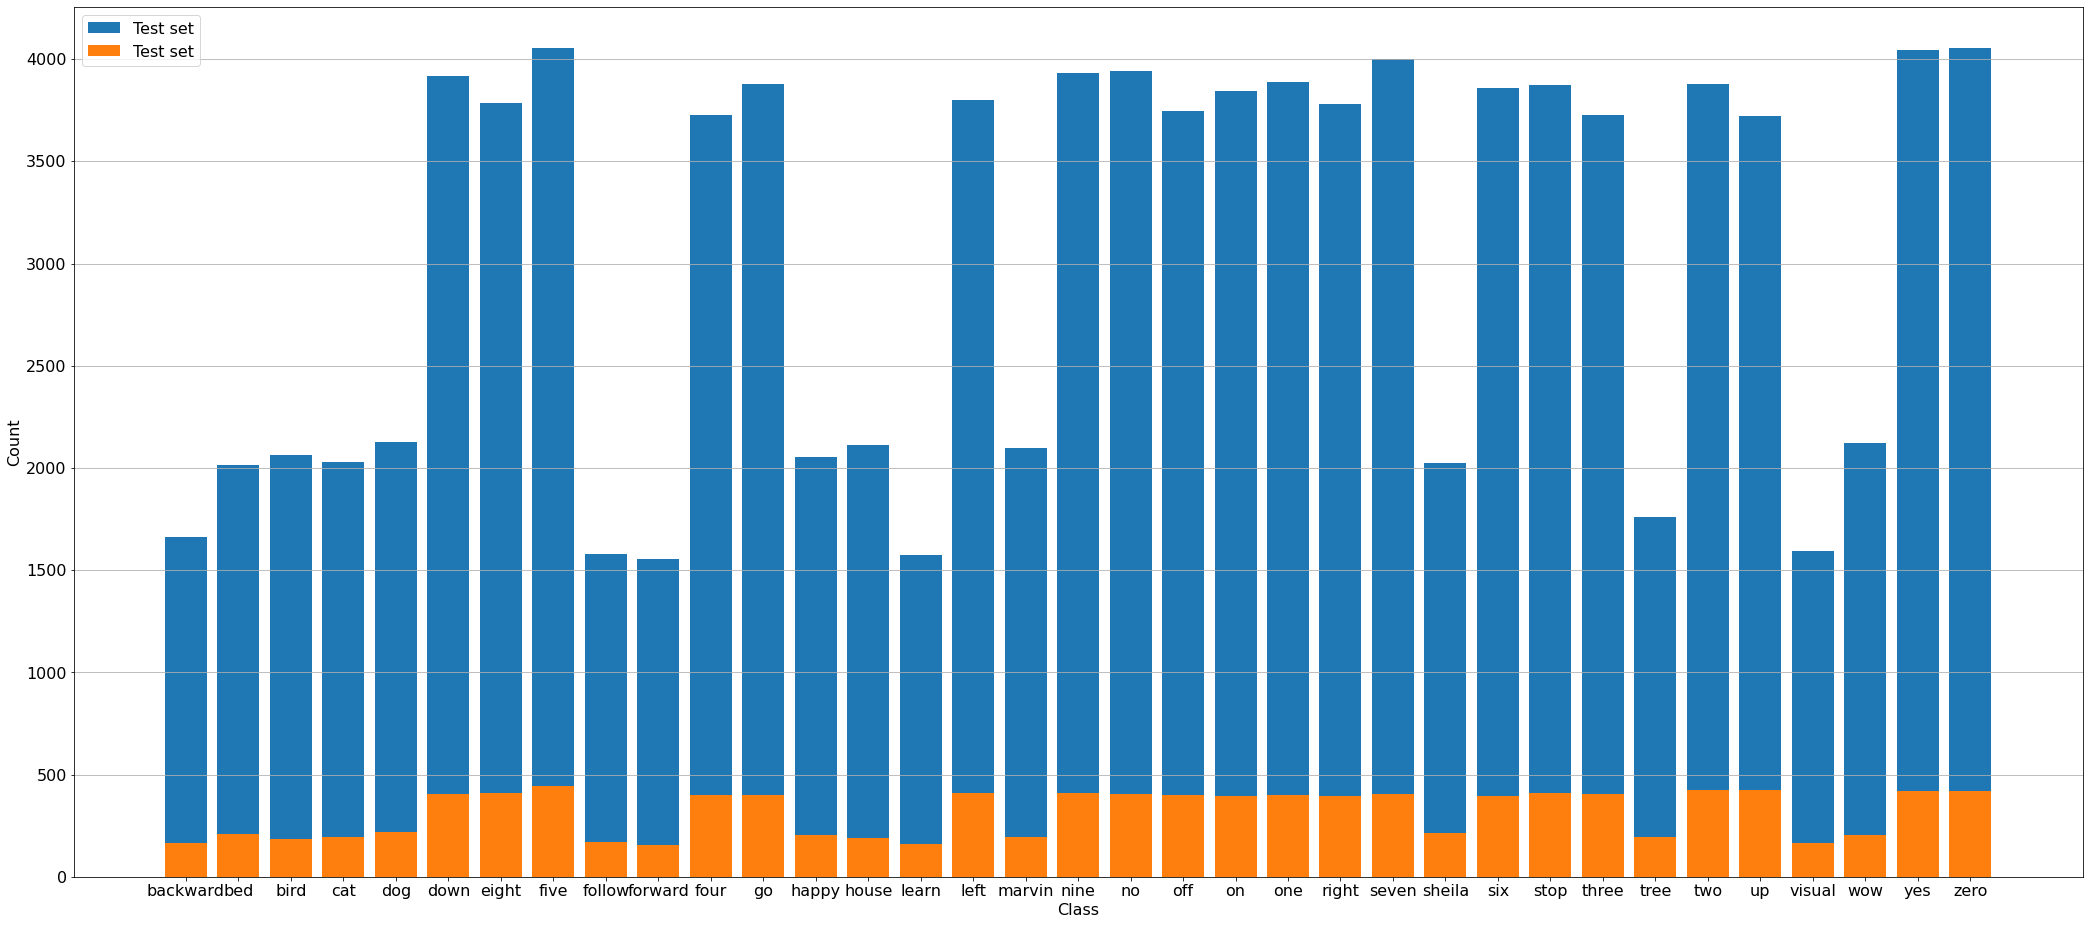

In [11]:
plt.rcParams['font.size'] = 20
num_per_class = np.unique([x[2] for x in train_set], return_counts=True)
plt.rcParams['figure.figsize'] = (36, 16)
plt.bar(num_per_class[0], num_per_class[1], label="Test set")
plt.xticks(np.arange(len(num_per_class[0])))
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid('on', axis='y')

num_per_class = np.unique([x[2] for x in test_set], return_counts=True)
plt.rcParams['figure.figsize'] = (32, 16)
plt.bar(num_per_class[0], num_per_class[1], label="Test set")
plt.xticks(np.arange(len(num_per_class[0])))
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid('on', axis='y')
plt.legend()
plt.show()
plt.rcParams['font.size'] = 12

In [21]:
# Lowerin sampling rate to 8000, doesn't really affect accuracy, lowers number of samples
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

# Train CNN model

In [8]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


def initialize_model(num_classes):
    """ Using M5 model """
    model = M5(n_input=num_channels, n_output=num_classes)
    
    if n_gpu > 1:  
        print("Paralel computing!")
        model = nn.DataParallel(model) # paralelizam
    return model

# CNN model initialization
model = initialize_model(num_classes)
model = model.to(device)
print(model)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)


## Training function

In [23]:
def train_model(model, dataloaders, criterion, optimizer, lr_scheduler, num_epochs=25):
    start = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []
    
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # training mode
            else:
                model.eval()   # test mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate through dataset
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # apply transform
                inputs = transform(inputs)
                optimizer.zero_grad()

                # forward phase
                with torch.set_grad_enabled(phase == 'train'):
                    # calculate loss and output from model
                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), labels)

                    if(n_gpu > 1):
                        loss = loss.mean()
                    _, preds = torch.max(outputs.squeeze(), 1)

                    # backward phase if training 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # lower learning rate if you get worse accuracy on validation set
            if phase == 'val' and epoch > 0 and epoch_acc < val_acc_history[-1]:
                lr_scheduler.step()
                
            # deep copy best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
                
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            if phase == 'val' and epoch%5 == 0:
                MODEL_PATH = "./model/m5_multigpu_epoch_{}.pt".format(epoch)
                if not os.path.exists(os.path.dirname(MODEL_PATH)):
                    os.makedirs(os.path.dirname(MODEL_PATH))
                torch.save(model.state_dict(), MODEL_PATH)
                    
        print()

    time_elapsed = time.time() - start
    print('Training finished in: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best accuracy: {:4f}'.format(best_acc))

    # loading best model
    model.load_state_dict(best_model)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

## Optimizer

In [9]:
params_to_update = model.parameters()
optimizer = optim.Adam(params_to_update)

decay_rate = 0.95
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

## Training

In [ ]:
criterion = F.nll_loss

# Treniranje
model, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(model, dataloaders_dict, criterion, optimizer, 
                                             lr_scheduler, num_epochs=30)

Epoch 1/30
----------
train Loss: 1.3625 Acc: 0.6171
val Loss: 1.1093 Acc: 0.6692

Epoch 2/30
----------
train Loss: 0.9174 Acc: 0.7364
val Loss: 0.7640 Acc: 0.7786

Epoch 3/30
----------
train Loss: 0.7760 Acc: 0.7749
val Loss: 0.7966 Acc: 0.7601

Epoch 4/30
----------
train Loss: 0.6852 Acc: 0.8023
val Loss: 0.6159 Acc: 0.8238

Epoch 5/30
----------
train Loss: 0.6349 Acc: 0.8138
val Loss: 0.5423 Acc: 0.8457

Epoch 6/30
----------
train Loss: 0.5971 Acc: 0.8256
val Loss: 0.5277 Acc: 0.8438

Epoch 7/30
----------
train Loss: 0.5600 Acc: 0.8354
val Loss: 0.4502 Acc: 0.8719

Epoch 8/30
----------
train Loss: 0.5360 Acc: 0.8422
val Loss: 0.4818 Acc: 0.8584

Epoch 9/30
----------
train Loss: 0.5123 Acc: 0.8485
val Loss: 0.4903 Acc: 0.8558

Epoch 10/30
----------
train Loss: 0.4920 Acc: 0.8535
val Loss: 0.4182 Acc: 0.8818

Epoch 11/30
----------
train Loss: 0.4778 Acc: 0.8578
val Loss: 0.4067 Acc: 0.8775

Epoch 12/30
----------
train Loss: 0.4628 Acc: 0.8632
val Loss: 0.3652 Acc: 0.8931

E

## Load/Save model

In [26]:
MODEL_PATH = "./model/m5_multigpu_best_30_epochs.pt"
#if not os.path.exists(os.path.dirname(MODEL_PATH)):
#    os.makedirs(os.path.dirname(MODEL_PATH))
#torch.save(model.state_dict(), MODEL_PATH)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [65]:
train_acc_history = [torch.Tensor.cpu(x).numpy() for x in train_acc_history]
val_acc_history = [torch.Tensor.cpu(x).numpy() for x in val_acc_history]

In [31]:
# Save/load loss and accuracy history arrray
load = True
if(load):
    train_acc_history = np.loadtxt("./model/m5_multigpu_30_epochs_tr_acc.txt")
    train_loss_history = np.loadtxt("./model/m5_multigpu_30_epochs_tr_loss.txt")
    val_acc_history = np.loadtxt("./model/m5_multigpu_30_epochs_val_acc.txt")
    val_loss_history = np.loadtxt("./model/m5_multigpu_30_epochs_val_loss.txt")
else:
    np.savetxt("./model/m5_multigpu_30_epochs_tr_acc1.txt", train_acc_history)
    np.savetxt("./model/m5_multigpu_30_epochs_tr_loss1.txt", train_loss_history)
    np.savetxt("./model/m5_multigpu_30_epochs_val_acc1.txt", val_acc_history)
    np.savetxt("./model/m5_multigpu_30_epochs_val_loss1.txt", val_loss_history)

## Loss and accuracy history during training

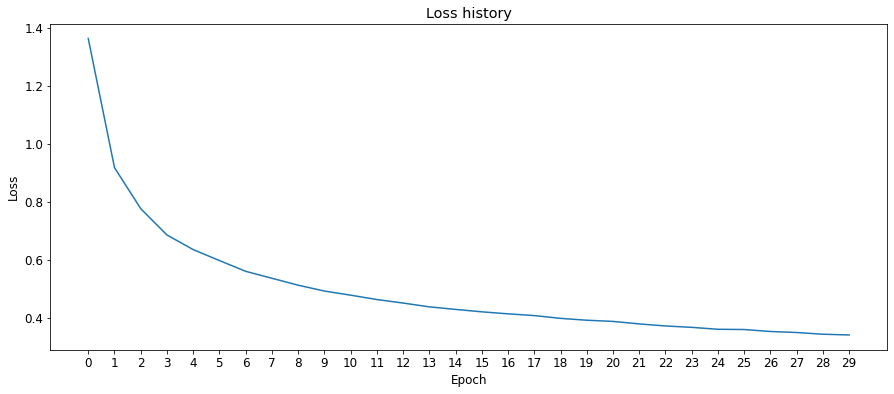

In [32]:
plt.title('Loss history')
plt.plot(train_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0,len(train_loss_history)))
plt.gcf().set_size_inches(15, 6)
plt.show()

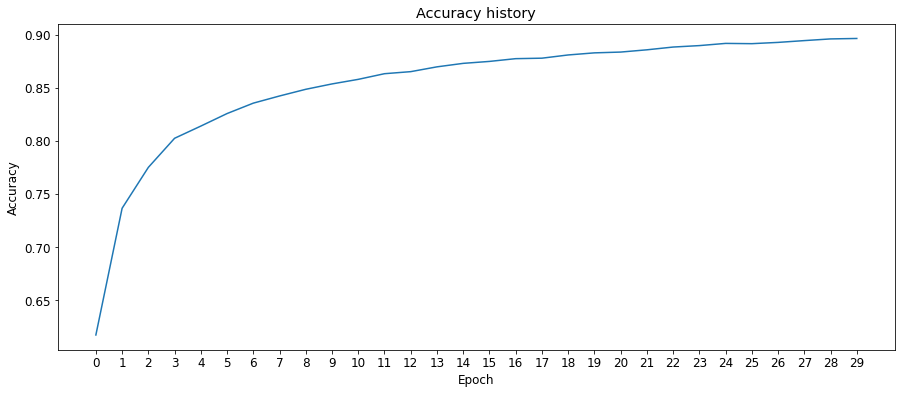

In [34]:
plt.title('Accuracy history')
plt.plot(train_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(0,len(train_acc_history)))
plt.gcf().set_size_inches(15, 6)
plt.show()

# Testing the model on test set

In [116]:
correct = 0
total = 0
inference_time = []
model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders_dict["test"]:
        
        inputs = inputs.to(device)
        inputs = transform(inputs)
        labels = labels.to(device)
        print(inputs.shape)
        print(labels.shape)
        
        start = time.time()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.squeeze(), 1)
        print(predicted.shape)
        print(outputs.shape)
        break
        
        inference_time.append((time.time() - start) / labels.size(0))
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Model accuracy ' + str(total) + ' test audios: %.2f %%' % (
    100 * correct / total))

inference_time = np.mean(inference_time, dtype='float64')
print('Average inference time: {:.0f} microseconds'.format(inference_time * 1e6))

print("Number of wrong predictions: " + str(total - correct) + " / " + str(total))

torch.Size([128, 1, 8000])
torch.Size([128])
torch.Size([128])
torch.Size([128, 1, 35])


ZeroDivisionError: division by zero

In [141]:
custom_set = []
labels = []
path = "./SpeechCommands/custom/*"
for file in glob.glob(path):
    audio = librosa.load(file, sr=16000)
    label = os.path.basename(file)[0]
    custom_set.append(torch.tensor(audio[0].reshape(1, audio[0].shape[0])))
    labels.append(int(label))

In [148]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for inputs, label in zip(custom_set, labels):
        inputs = inputs.reshape((1, inputs.shape[0], inputs.shape[1]))
        inputs = inputs.to(device)
        inputs = transform(inputs)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.flatten(), 0)
        predicted = torch.Tensor.cpu(predicted).numpy()
        
        total += 1
        correct += (predicted == label)
        
print('Model accuracy ' + str(total) + ' test audios: %.2f %%' % (
    100 * correct / total))

inference_time = np.mean(inference_time, dtype='float64')
print('Average inference time: {:.0f} microseconds'.format(inference_time * 1e6))

print("Number of wrong predictions: " + str(total - correct) + " / " + str(total))

Model accuracy 10 test audios: 100.00 %
Average inference time: nan microseconds
Number of wrong predictions: 0 / 10


In [ ]:
print(dataloaders_dict)

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import librosa
import os
import random
import time
import copy
import numpy as np
import warnings
warnings.filterwarnings('ignore')


def predict_class():

    class M5(nn.Module):
        def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
            super().__init__()
            self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
            self.bn1 = nn.BatchNorm1d(n_channel)
            self.pool1 = nn.MaxPool1d(4)
            self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
            self.bn2 = nn.BatchNorm1d(n_channel)
            self.pool2 = nn.MaxPool1d(4)
            self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
            self.bn3 = nn.BatchNorm1d(2 * n_channel)
            self.pool3 = nn.MaxPool1d(4)
            self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
            self.bn4 = nn.BatchNorm1d(2 * n_channel)
            self.pool4 = nn.MaxPool1d(4)
            self.fc1 = nn.Linear(2 * n_channel, n_output)

        def forward(self, x):
            x = self.conv1(x)
            x = F.relu(self.bn1(x))
            x = self.pool1(x)
            x = self.conv2(x)
            x = F.relu(self.bn2(x))
            x = self.pool2(x)
            x = self.conv3(x)
            x = F.relu(self.bn3(x))
            x = self.pool3(x)
            x = self.conv4(x)
            x = F.relu(self.bn4(x))
            x = self.pool4(x)
            x = F.avg_pool1d(x, x.shape[-1])
            x = x.permute(0, 2, 1)
            x = self.fc1(x)
            return F.log_softmax(x, dim=2)

    def initialize_model(num_classes):
        """ Using M5 model """
        model = M5(n_input=1, n_output=num_classes)
        return model

    # CNN model initialization
    num_classes = 35
    device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = initialize_model(num_classes)
    model = model.to(device)

    transform = torchaudio.transforms.Resample(orig_freq=16000, new_freq=8000)
    MODEL_PATH = "./model/m5_multigpu_best_30_epochs.pt"
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

    custom_set = []
    labels = []
    path = "./SpeechCommands/custom/*"
    for file in glob.glob(path):
        print(file)
        audio = librosa.load(file, sr=16000)
        label = os.path.basename(file)[0]
        custom_set.append(torch.tensor(audio[0].reshape(1, audio[0].shape[0])))
        labels.append(int(label))
    
    predictions = []
    
    model.eval()
    with torch.no_grad():
        for inputs, label in zip(custom_set, labels):
            inputs = inputs.reshape((1, inputs.shape[0], inputs.shape[1]))
            inputs = inputs.to(device)
            inputs = transform(inputs)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.flatten(), 0)
            predicted = torch.Tensor.cpu(predicted).numpy()
            predictions.append(int(predicted))
    print("label: ", labels)
    print("predicted: ", predictions)
    return [predicted]

predict_class()

./SpeechCommands/custom\0_adisa.wav
./SpeechCommands/custom\1_adisa.wav
./SpeechCommands/custom\2_adisa.wav
./SpeechCommands/custom\3_adisa.wav
./SpeechCommands/custom\4_adisa.wav
./SpeechCommands/custom\5_adisa.wav
./SpeechCommands/custom\6_adisa.wav
./SpeechCommands/custom\7_adisa.wav
./SpeechCommands/custom\8_adisa.wav
./SpeechCommands/custom\9_adisa.wav
label:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
predicted:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


[array(9, dtype=int64)]